### 명준님 코드 + KcELECTRA

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# 데이터 로드 및 전처리
######################
# 데이터 예시: train.csv -> columns: [conversation, class]
# test.csv -> columns: [conversation]
train_df = pd.read_csv("/aiffel/aiffel/dlthon/conversation_train.csv")
test_df = pd.read_csv("/aiffel/aiffel/dlthon/test.csv")

# 클래스 인코딩
labels = train_df["class"].unique().tolist()
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])  # 0~4로 변환

# 클래스별 20% Validation Split
X = train_df["conversation"].values
y = train_df["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)
train_df_split = pd.DataFrame({"conversation": X_train, "label": y_train})
val_df_split = pd.DataFrame({"conversation": X_val, "label": y_val})

In [3]:
# Dataset 정의
######################
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        if self.labels is not None:
            label = self.labels[idx]
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask
            }

In [4]:
# 토크나이저 및 데이터로더
######################
# model_name = "monologg/kobigbird-bert-base"
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
train_dataset = TextDataset(train_df_split["conversation"].values,
                            train_df_split["label"].values,
                            tokenizer=tokenizer, max_len=512)
val_dataset = TextDataset(val_df_split["conversation"].values,
                          val_df_split["label"].values,
                          tokenizer=tokenizer, max_len=512)
test_dataset = TextDataset(test_df["text"].values,
                           labels=None,
                           tokenizer=tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [7]:
# 훈련 세팅
######################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataParallel을 통해 멀티 GPU 활용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

epochs = 3
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
total_steps = len(train_loader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(total_steps*0.1),
                                            num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss()

In [8]:
from sklearn.metrics import f1_score

In [9]:
# 학습 루프
######################
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # 다중 클래스 F1 스코어 (macro) 계산
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

Epoch 1 [Val]: 100%|██████████| 588/588 [01:19<00:00,  7.43it/s]


Epoch 1: Train Loss: 0.5936, Val Loss: 0.2214, Val F1: 0.9197


Epoch 2 [Val]: 100%|██████████| 588/588 [01:19<00:00,  7.44it/s]


Epoch 2: Train Loss: 0.1530, Val Loss: 0.1687, Val F1: 0.9442


Epoch 3 [Val]: 100%|██████████| 588/588 [01:18<00:00,  7.44it/s]


Epoch 3: Train Loss: 0.0618, Val Loss: 0.1650, Val F1: 0.9460


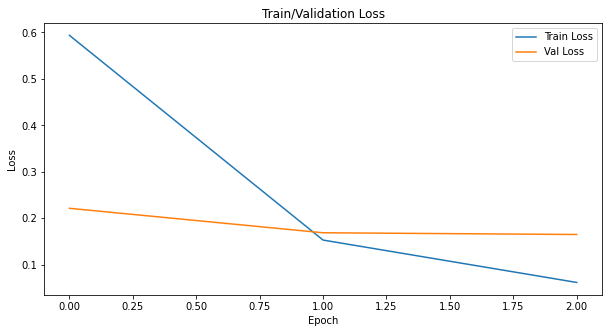

In [10]:
# Loss 시각화
######################
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Train/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
# 테스트 데이터 예측
######################
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Prediction"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# 예측 라벨 복원
pred_labels = label_encoder.inverse_transform(predictions)

# 결과 저장
test_df["pred_class"] = pred_labels
test_df.to_csv("test_predictions.csv", index=False)

Test Prediction: 100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


In [12]:
test_df['pred_class'].value_counts()

직장 내 괴롭힘 대화    112
기타 괴롭힘 대화      111
갈취 대화          105
협박 대화          102
일반              70
Name: pred_class, dtype: int64

In [13]:
sub = pd.read_csv('/aiffel/aiffel/dlthon/submission.csv')

In [14]:
sub['class'] = test_df['pred_class']

In [15]:
sub['idx'] = sub['file_name']
sub['target'] = sub['class']
sub = sub.drop(columns=['file_name','class'])
sub = sub[['idx', 'target']]
sub['target'] = sub['target'].apply(lambda x: 0 if x == '협박 대화' else
                                               1 if x == '갈취 대화' else
                                               2 if x == '직장 내 괴롭힘 대화' else
                                               3 if x == '기타 괴롭힘 대화' else
                                               4 if x == '일반' else None)


In [16]:
sub

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,4
4,t_004,1
...,...,...
495,t_495,2
496,t_496,1
497,t_497,1
498,t_498,2


In [17]:
sub.to_csv('submission_kcelectra_base_00.csv', index=False, encoding='utf-8-sig')